In [ ]:
%load_ext autoreload
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.utils import select_rows, sparsity_aware_dist, polis_umap, polis_pca

# Visualization parameters
plt.figure(figsize=(500, 500));
sns.set_context('poster');
sns.set_style('white');
sns.set(font_scale=.7);
sns.set_color_codes();
np.seterr(divide='ignore', invalid='ignore');

# Import data

In [ ]:
# Import participants votes
df = pd.read_csv('Data/american-assembly.bowling-green/participants-votes.csv',index_col='participant')
df.head(3)

In [ ]:
# Import participants' comments
df_comments = pd.read_csv('Data/american-assembly.bowling-green/comments.csv',index_col='comment-id')
df_comments.index = df_comments.index.astype(str)
df_comments.head(3)

In [ ]:
# Set Metadata fields and variable fields
metadata_fields = ['group-id', 'n-comments', 'n-votes', 'n-agree', 'n-disagree']
val_fields = [c for c in df.columns.values if c not in metadata_fields]

# remove statements (columns) which were moderated out
# df_comments["moderated"] = 0   --->   comment should be removed
statements_all_in = sorted(list(df_comments.loc[df_comments["moderated"] > 0].index.array), key = int)

# Remove participants with less than N (threshold) votes.
df = select_rows(df=df, val_fields=val_fields, threshold=60)

# Preprocess
metadata = df[metadata_fields]
vals = df[val_fields]
# If the participant didn't see the statement, it's a null value, here we fill in the nulls with zeros
vals = vals.fillna(0)
vals = vals.sort_values("participant")

## Overall statistics

In [ ]:
melted = vals.melt();
all_votes = melted.count();
by_type = melted["value"].value_counts();
total_possible_votes = all_votes["value"];
total_agrees = by_type[1.0];
total_disagrees = by_type[-1.0];
total_without_vote = by_type[0.0];

print("Dimensions of matrix:", df.shape)
print("Dimensions of matrix:", vals.shape)
print("Total number of possible votes:", total_possible_votes)
print("Total number of agrees:", total_agrees)
print("Total number of disagrees:", total_disagrees)
print("Total without vote:", total_without_vote)
print("Percent sparse: ", total_without_vote / total_possible_votes,"%")

## Make sure to check how many people and votes, relative to the total matrix, you are losing given min vote threshold

## Comment selection

In [ ]:
vals_all_in = vals[statements_all_in]

high_variance = ["20","26","90"]
vals_high_variance = vals[high_variance]

## Opinion matrix 

**Opinion matrix = Full participants * comments matrix**

- How sparse is the dataset? How much agree, how much disagree, how much pass? Zero is 'passed' or 'did not see the comment to vote on it'. 1 is agree, -1 is disagree

- Some things to notice about the matrix: comments are submitted over time, so participants who do not return will only have voted on the statements which were available when they arrived. 

- Long horizontal lines: participants who do return show up as a horizontal line sticking out into otherwise blank areas

- Blank vertical lines: most likely statements which were moderated out of the conversation. 

In [ ]:
# Check sparcity of 'Opinion Matrix'
fig, ax = plt.subplots(figsize=(14,14));
sns.heatmap(vals_all_in, center=0, cmap="RdYlBu", ax=ax, cbar=False);

## Is the space explained by how much people vote?

In this chart, we take the PCA coordinates and color the participant locations by the number of total votes. Hopefully, it looks random. If it doesn't, we might imagine the following scenario:

1. 1000 people vote, and there are very few controversial statements. They do not return.
2. 1 person submits a statement which is incredibly controversial. 
3. 1000 more people vote, the space begins to take on structure, PCA is closely linked to vote count.

We know this scenario - that voters don't see controversial comments - happens. Polis mitigates in two ways:
* polis eliminates participants who don't vote at least 7 times from the analysis
* polis shows several highly controversial comments (large egeinvalue) in the first 10 comments participants see

## Application example
- Communities detection

In [22]:
import igraph as ig
import leidenalg
import louvain
from sklearn.neighbors import kneighbors_graph
from utils.community_detection import show_embedding


# Thanks to https://github.com/ciortanmadalina/high_noise_clustering/blob/master/graph-partitioning-louvain.ipynb
def polis_community_detection(dataframe=None, neighbors=2, type='Leiden', metric=sparsity_aware_dist):
    '''
        Pol.is community detection using kNN graph

        Parameters
        ----------
        dataframe: dataframe with participants votes
        neighbors: number of neighbors (default=2)
        type: 'Leiden' (default) or 'Louvain'
        metric: distance metric

        Returns
        -------
        Clusters obtaining the communities
    '''
    # Community detection
    A = kneighbors_graph(
        dataframe.values, 
        neighbors, 
        mode="connectivity",  
        metric=metric,        
        metric_params=None, 
        include_self=True, 
        n_jobs=None
    )

    sources, targets = A.nonzero()
    weights = A[sources, targets]
    if isinstance(weights, np.matrix): # ravel data
            weights = weights.A1

    g = ig.Graph(directed=False)
    g.add_vertices(A.shape[0])  # each observation is a node
    edges = list(zip(sources, targets))
    g.add_edges(edges)

    g.es['weight'] = weights
    weights = np.array(g.es["weight"]).astype(np.float64)

    if (type == 'Leiden'):
        # Clustering based on Leidenalg
        part = leidenalg.find_partition(g, leidenalg.ModularityVertexPartition);
        Clusters = np.array(part.membership)        
    else:        
        # Clustering based on Louvain algorithm
        resolution_parameter = 1.5
        partition_type = louvain.RBConfigurationVertexPartition
        partition_kwargs = {"weights": weights, "resolution_parameter": resolution_parameter}
        part = louvain.find_partition(g, partition_type, **partition_kwargs)
        Clusters = np.array(part.membership)

    return Clusters



def polis_subconversation(dataframe, clustering_type='Leiden', comments=None):
    print('[INFO] Application of PCA', end=': ')
    coords, explained_variance = polis_pca(dataframe, 2)
    print('Complete')
    print("Explained variance:", explained_variance)

    print('[INFO] Application of UMAP', end=': ')
    embedding = polis_umap(dataframe, 4);
    print('Complete')

    print(f'[INFO] Application of {clustering_type} clustering', end=': ')
    leidenClusters = polis_community_detection(dataframe=dataframe, neighbors=8, type=clustering_type)
    print('Complete')
    print('[INFO] Number of communities (clusters): ', np.unique(leidenClusters).shape[0])
    

    # Show clusters given PCA embedding 
    title = f"{clustering_type} detected communities in PCA space"
    show_embedding(coords, leidenClusters, title)   
    
    # Show clusters given umap embedding 
    title = f"{clustering_type} detected communities in UMAP space"
    show_embedding(embedding, leidenClusters, title)   
    
    
    # Show clustermap
    dataframe['cluster_assignments'] = leidenClusters
    clusters_by_comments_means = dataframe.groupby('cluster_assignments').agg('mean')

    sns.heatmap(clusters_by_comments_means, cmap="RdYlBu")
    sns.clustermap(clusters_by_comments_means, cmap="RdYlBu")

    return coords, embedding, dataframe

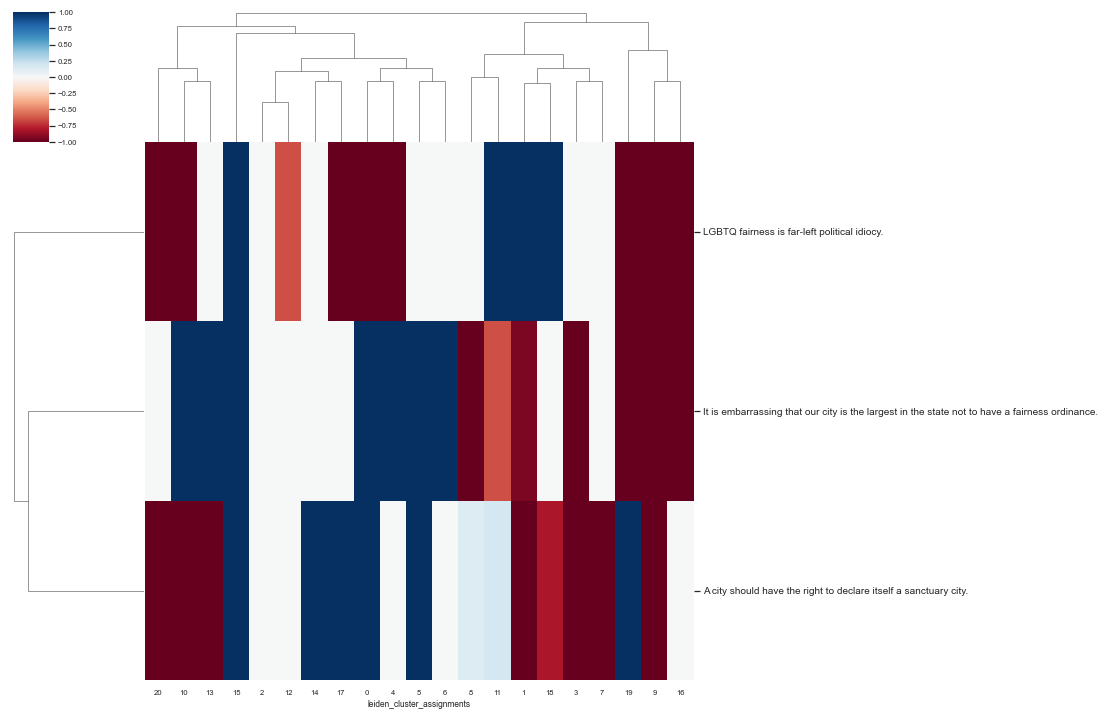

In [20]:
def polis_heatmap(__dataframe):
    leidenClusters = polis_community_detection(__dataframe, 8)

    __dataframe['leiden_cluster_assignments'] = leidenClusters
    clusters_by_comments_means = __dataframe.groupby('leiden_cluster_assignments').agg('mean').T

    index_to_label = df_comments['comment-body'].to_dict() # {index: label}

    clustergrid = sns.clustermap(clusters_by_comments_means, cmap="RdBu", figsize=(10,10), )

    ax = clustergrid.ax_heatmap
    new_labels = [index_to_label[str(idx._text)] for idx in ax.get_yticklabels()] # [ label0, label1, label2, ...]
    ax.set_yticklabels(new_labels, rotation=0, fontsize=10)
    
    
polis_heatmap(vals_high_variance)

[INFO] Application of PCA: Complete
Explained variance: [0.12267305 0.06782146]
[INFO] Application of UMAP: Complete
[INFO] Application of Leiden clustering: Complete
[INFO] Number of communities (clusters):  7


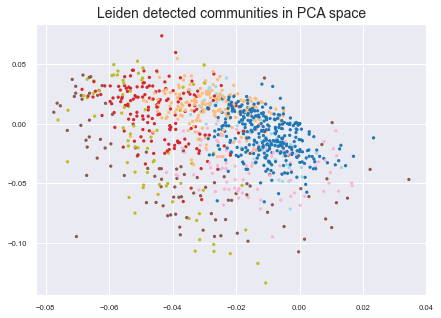

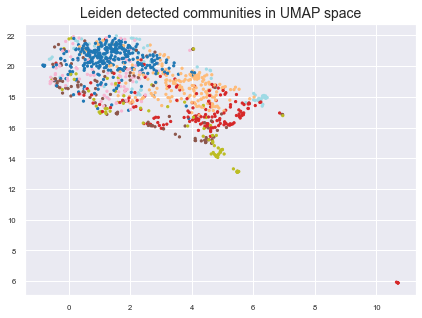

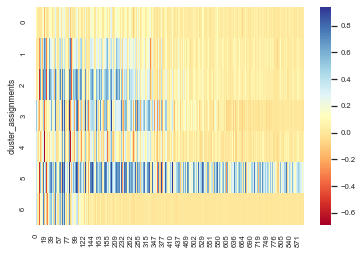

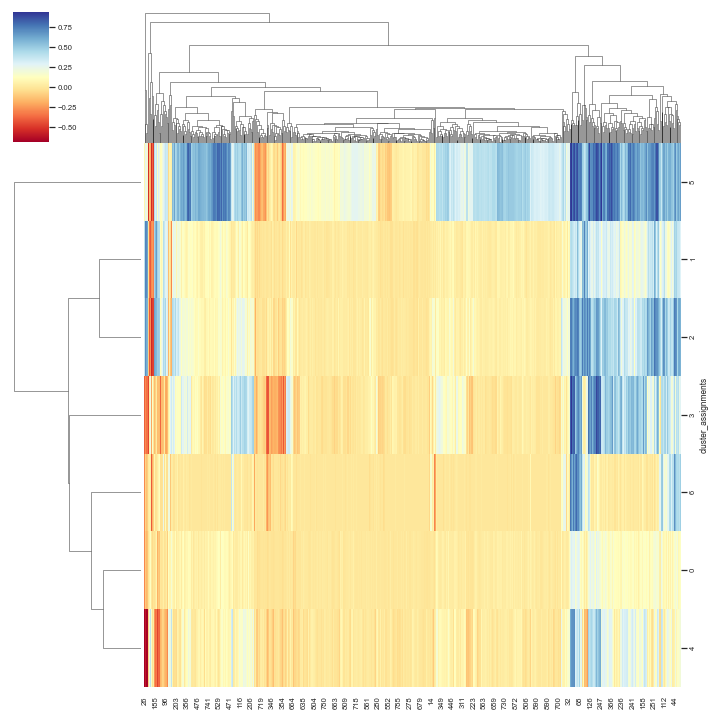

In [23]:
coords, embedding, _ = polis_subconversation(vals_all_in, clustering_type='Leiden', comments=['5'])

# coords, embedding, _ = polis_subconversation(vals_all_in, clustering_type='Louvain', comments=['5'])

Comment No 4: Most local officials run for office to serve the public good.


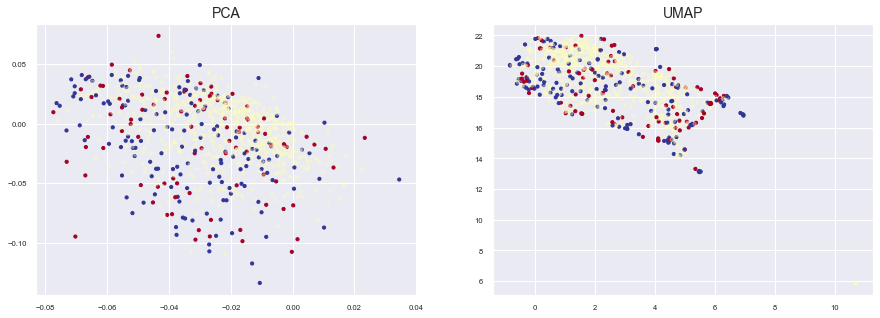

Comment No 5: Local law enforcement would benefit from additional training in community relations.


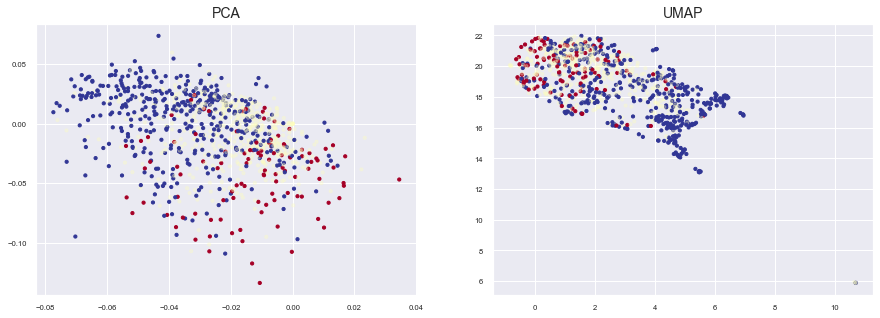

In [24]:
from utils.utils import comment_visualization

comments_ids = ['4', '5']

# Opinion of select community about specific comments
for x in comments_ids:
    comment = df_comments['comment-body'][x]
    comment_visualization(dataframe=vals_all_in, comment_id=x, comment=comment, coords=coords, embedding=embedding)